In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot
import torchvision
from models.vt_resnet import vt_resnet18

In [11]:
transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

In [2]:
labels_dir = '/datasets/ImageNet/ILSVRC2015/devkit/data'
train_labels_file = 'map_clsloc.txt'
valid_labels_file = 'ILSVRC2015_clsloc_validation_ground_truth.txt'
train_labels_path = os.path.join(labels_dir, train_labels_file)
valid_labels_path = os.path.join(labels_dir, valid_labels_file)
train_data_dir = '/datasets/ImageNet/ILSVRC2015/Data/CLS-LOC/train'
valid_data_dir = '/datasets/ImageNet/ILSVRC2015/Data/CLS-LOC/val'

In [99]:
fl = []
with open(valid_labels_path, "r") as f:
    for e in f:
        fl.append(int(e[:-1]))

In [102]:
max(fl)

1000

In [121]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

path = os.path.join(valid_data_dir, valid_data_folders[10])

img = mpimg.imread(path)

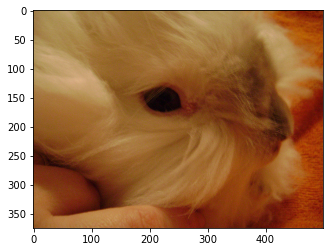

TypeError: expected np.ndarray (got int)

In [103]:
train_data_folders = os.listdir(train_data_dir)
valid_data_folders = os.listdir(valid_data_dir)

In [105]:
valid_data_folders

['ILSVRC2012_val_00027112.JPEG',
 'ILSVRC2012_val_00000001.JPEG',
 'ILSVRC2012_val_00000002.JPEG',
 'ILSVRC2012_val_00000003.JPEG',
 'ILSVRC2012_val_00000004.JPEG',
 'ILSVRC2012_val_00000005.JPEG',
 'ILSVRC2012_val_00000006.JPEG',
 'ILSVRC2012_val_00000007.JPEG',
 'ILSVRC2012_val_00000008.JPEG',
 'ILSVRC2012_val_00000009.JPEG',
 'ILSVRC2012_val_00000010.JPEG',
 'ILSVRC2012_val_00000011.JPEG',
 'ILSVRC2012_val_00000012.JPEG',
 'ILSVRC2012_val_00000013.JPEG',
 'ILSVRC2012_val_00000014.JPEG',
 'ILSVRC2012_val_00000015.JPEG',
 'ILSVRC2012_val_00000016.JPEG',
 'ILSVRC2012_val_00000017.JPEG',
 'ILSVRC2012_val_00000018.JPEG',
 'ILSVRC2012_val_00000019.JPEG',
 'ILSVRC2012_val_00000020.JPEG',
 'ILSVRC2012_val_00000021.JPEG',
 'ILSVRC2012_val_00000022.JPEG',
 'ILSVRC2012_val_00000023.JPEG',
 'ILSVRC2012_val_00000024.JPEG',
 'ILSVRC2012_val_00000025.JPEG',
 'ILSVRC2012_val_00000026.JPEG',
 'ILSVRC2012_val_00000027.JPEG',
 'ILSVRC2012_val_00000028.JPEG',
 'ILSVRC2012_val_00000029.JPEG',
 'ILSVRC20

In [93]:
files_sample = os.listdir(os.path.join(train_data_dir, train_data_folders[600]))

In [91]:
len(files_sample)

1300

In [57]:
import os
import matplotlib.image as mpimg
import torch
from torch.utils.data import Dataset

class ImageNetDataset(Dataset):
    """
    A DataLoader for ImageNet Dataset designed specifically for KU HPC Cluster.
    """
    labels_dir = '/datasets/ImageNet/ILSVRC2015/devkit/data'
    train_labels_file = 'map_clsloc.txt'
    valid_labels_file = 'ILSVRC2015_clsloc_validation_ground_truth.txt'
    train_labels_path = os.path.join(labels_dir, train_labels_file)
    valid_labels_path = os.path.join(labels_dir, valid_labels_file)
    train_data_dir = '/datasets/ImageNet/ILSVRC2015/Data/CLS-LOC/train'
    valid_data_dir = '/datasets/ImageNet/ILSVRC2015/Data/CLS-LOC/val'
    
    def __init__(self, train: bool, transform=None):

        self.transform = transform
        
        self.class_id_to_index = {}
        self.class_index_to_name = {}
        self.class_name_to_index = {}
        self.train = train
        
        # store labels
        self.labels = []
        # store paths to images
        self.data = []
        
        # get classed mapping
        train_f = open(self.train_labels_path, "r") 
        for line in train_f:
            ID, index, name = line[:-1].split(' ')
            index = int(index)
            self.class_id_to_index[ID] = index
            self.class_index_to_name[index] = name
            self.class_name_to_index[name] = index
        
        if train:
            train_data_folders = os.listdir(self.train_data_dir)
            for ID in train_data_folders:
                label = self.class_id_to_index[ID]
                label_path = os.path.join(self.train_data_dir, ID)
                for data_file in os.listdir(label_path):
                    self.data.append(os.path.join(label_path, data_file))
                    self.labels.append(label)
        else:
            valid_f = open(self.valid_labels_path, "r")
            for line in valid_f:
                self.labels.append(int(line[:-1]))
            for data_file in sorted(os.listdir(self.valid_data_dir)):
                self.data.append(os.path.join(self.valid_data_dir, data_file))
            
            
    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, index):
        
        label = self.labels[index] - 1
        data_path = self.data[index]
        data = mpimg.imread(data_path)
        
        # some images might have 1 channel
        if len(data.shape) < 3:
            H, W = data.shape
            data_temp = data.copy()
            data = np.zeros((H, W, 3))
            for i in range(3):
                data[:,:,i] = data_temp
            
            data = data.astype(np.uint8)
        
        if self.transform:
            data = self.transform(data)
        
        return data, label
        

In [58]:
import torchvision
import matplotlib.pyplot as plt
transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize((224, 224))
    ])

In [59]:
dataset = ImageNetDataset(train=True, transform=transform)

In [62]:
sample, label = dataset[407]

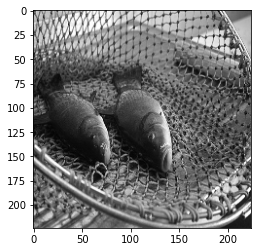

In [63]:
plt.imshow(sample.permute(1, 2, 0))

In [284]:
dataset.class_index_to_name[label]

'great_white_shark'

In [70]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [71]:
d = None
for a in dataloader:
    d = a
    break

In [73]:
len(d[0])

64